# Method 1: time-series forcasting using ARIMA

### 1. Import data

In [148]:
import datetime
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
import numpy as np
from matplotlib import pyplot

In [117]:
dir = '/Users/yuanxizhu/Downloads/fintech/data.csv'
data = pd.read_csv(dir, parse_dates=['Date'], index_col=['Date'])
# prices = pd.Series(data['Close']).values
data = data.drop(columns=['Open', 'High','Low','Volume'])
# data

In [118]:
# data.values
# from pandas.plotting import autocorrelation_plot
# autocorrelation_plot(data.values)
# pyplot.show()

### 2. Check for stationality 
#### Check visually that it is not stationary:

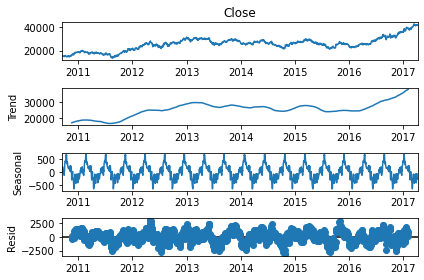

In [119]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(data['Close'], model='additive', period = 91)
fig = decomposition.plot()
pyplot.show()

####  Augmented Dickey-Fuller Test


In [120]:
from statsmodels.tsa.stattools import adfuller
adftest = adfuller(data)
print(adftest[1])

0.8978963725565924


### 3. Determine value for p, q, d

In [121]:
d1 = data.diff().dropna()

adftest = adfuller(d1)
print(adftest[1])

0.0


Differencing once makes the data stationary

#### Partial Autocorrelation plot to determine p 

In [122]:
from statsmodels.graphics.tsaplots import plot_pacf

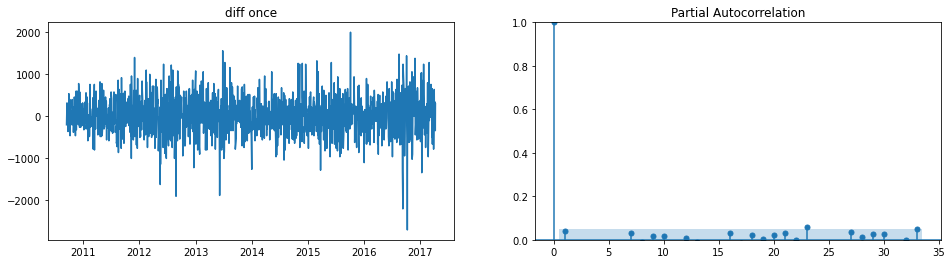

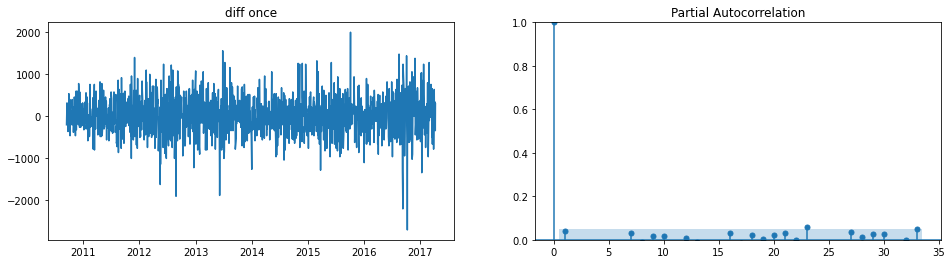

In [123]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize = (16, 4))

ax1.set_title("diff once")
ax1.plot(d1)
ax2.set_ylim(0, 1)
plot_pacf(d1, ax=ax2)

#### Autocorrelation plot to determine q

In [124]:
from statsmodels.graphics.tsaplots import plot_acf

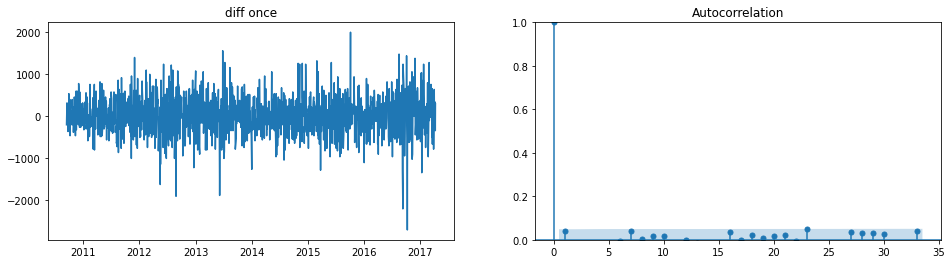

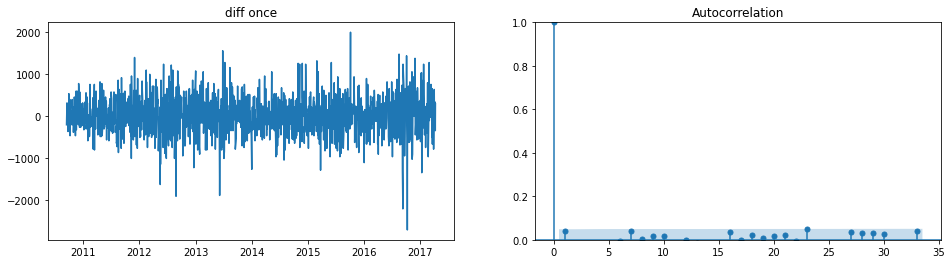

In [125]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize = (16, 4))

ax1.set_title("diff once")
ax1.plot(d1)
ax2.set_ylim(0, 1)
plot_acf(d1, ax=ax2)

### 4. ARIMA model

In [213]:
from statsmodels.tsa.arima.model import ARIMA
train = d1[:1000]
model = ARIMA(train.values, order=(1,1,1)).fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7431.344
Date:                Wed, 08 Dec 2021   AIC                          14868.689
Time:                        21:15:19   BIC                          14883.409
Sample:                             0   HQIC                         14874.284
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0303      0.032      0.954      0.340      -0.032       0.092
ma.L1         -1.0000      0.362     -2.766      0.006      -1.709      -0.291
sigma2      1.682e+05   6.13e+04      2.745      0.0

### 5. Test predictions

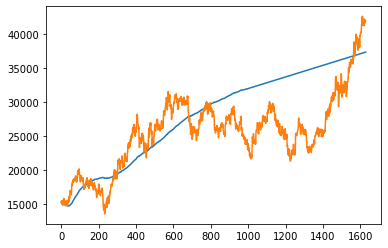

In [227]:
pred = model.predict(start=0, end=1627)
result = []
arr_data = np.array(data).reshape(1628)
result.append(arr_data[0])

for i in range(len(pred)):
    result.append(result[i] + pred[i])

pyplot.plot(result)
pyplot.plot(arr_data)

d1

### 6. Write to submission file

In [231]:
pred = model.predict(start=1628, end=1627+1086)
sub = []
arr_data = np.array(data).reshape(1628)
sub.append(arr_data[-1])

for i in range(len(pred)):
    sub.append(sub[i] + pred[i])


[41900,
 41908.49734182466,
 41916.99468364932,
 41925.49202547398,
 41933.989367298636,
 41942.486709123295,
 41950.984050947955,
 41959.48139277261,
 41967.97873459727,
 41976.47607642193,
 41984.97341824659,
 41993.47076007125,
 42001.96810189591,
 42010.46544372057,
 42018.96278554523,
 42027.460127369886,
 42035.957469194545,
 42044.454811019204,
 42052.95215284386,
 42061.44949466852,
 42069.94683649318,
 42078.44417831784,
 42086.9415201425,
 42095.43886196716,
 42103.93620379182,
 42112.43354561648,
 42120.930887441136,
 42129.428229265795,
 42137.925571090454,
 42146.42291291511,
 42154.92025473977,
 42163.41759656443,
 42171.91493838909,
 42180.41228021375,
 42188.90962203841,
 42197.40696386307,
 42205.90430568773,
 42214.401647512386,
 42222.898989337045,
 42231.396331161704,
 42239.89367298636,
 42248.39101481102,
 42256.88835663568,
 42265.38569846034,
 42273.883040285,
 42282.38038210966,
 42290.87772393432,
 42299.37506575898,
 42307.872407583636,
 42316.369749408295,
 

In [232]:
sub = pd.DataFrame(sub, columns =['pred'])
submission = pd.read_csv('/Users/yuanxizhu/Downloads/fintech/test.csv')

submission['Predicted'] = sub['pred']
submission.to_csv('/Users/yuanxizhu/Downloads/fintech/test2.csv',index = False)

# Method 2: time-series forcasting using Machine Learning

### 1. Import data

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
dir = '/Users/yuanxizhu/Downloads/fintech/data.csv'
data = pd.read_csv(dir)
# prices = pd.Series(data['Close']).values
data = data.drop(columns=['Date','Open', 'High','Low','Volume'])

### 2. Data preprocessing

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
data = scaler.fit_transform(data)
data = pd.DataFrame(data)

#### Split data into train and test sets

Feature: the number of previous days of stock price that we set as input to get output price of some day

Here, I set feature=3 for ease of computation. Setting features to be a larger number may result in more accurate predictions

In [ ]:
def get_trainset(traindata, feature=3):
    p = feature
    y_train = np.array(traindata)[p:]
    x_train = []
    for i in range(0, len(traindata)-p):
        x_train.append(traindata.iloc[i:i+p])
    x_train = np.array(x_train)
    train_data = []

    return x_train, y_train

x_train, y_train = get_trainset(data[:1000])
X = x_train.reshape(x_train.shape[0], x_train.shape[1])
testX, testY = get_trainset(data[997:])
testX = testX.reshape(testX.shape[0], testX.shape[1])

### 3. Train the model

In [ ]:
model = Sequential()
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
model.fit(X, y_train, epochs=80, batch_size=1)

### 4. Test the model

In [ ]:
def make_prediction(model, initial, n): # n is the number of days ahead we need to predict
    output = []
    temp_input = list(initial)
    for i in range(0, n):
        
        prediction = model.predict(np.array(temp_input).reshape(1, 5))
        for j in range(len(temp_input)-1):
            temp_input[j] = temp_input[j+1]
        temp_input[-1]  = prediction[0,0]
        output.append(prediction)
    output = np.array(output)[:,0]
    return output

In [ ]:
prediction = make_prediction(model, np.array(data[995:1000])[:,0], len(data)-1000)
scaledpred = scaler.inverse_transform(prediction)
testScore = math.sqrt(mean_squared_error(testY_inverse[:,0], scaledpred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))prediction = make_prediction(model, np.array(data[995:1000])[:,0], len(data)-1000)
scaledpred = scaler.inverse_transform(prediction)
testScore = math.sqrt(mean_squared_error(testY_inverse[:,0], scaledpred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [27]:
prediction = make_prediction(model, np.array(data[995:1000])[:,0], len(data)-1000)
scaledpred = scaler.inverse_transform(prediction)
testScore = math.sqrt(mean_squared_error(testY_inverse[:,0], scaledpred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 192324.69 RMSE


array([[ 23706.596],
       [ 23728.756],
       [ 23715.975],
       [ 23756.377],
       [ 23797.836],
       [ 23841.332],
       [ 23880.277],
       [ 23919.285],
       [ 23958.578],
       [ 23998.637],
       [ 24039.041],
       [ 24079.746],
       [ 24120.727],
       [ 24162.023],
       [ 24203.645],
       [ 24245.594],
       [ 24287.87 ],
       [ 24330.477],
       [ 24373.412],
       [ 24416.682],
       [ 24460.293],
       [ 24504.244],
       [ 24548.535],
       [ 24593.172],
       [ 24638.156],
       [ 24683.492],
       [ 24729.182],
       [ 24775.225],
       [ 24821.63 ],
       [ 24868.4  ],
       [ 24915.531],
       [ 24963.03 ],
       [ 25010.898],
       [ 25059.14 ],
       [ 25107.758],
       [ 25156.756],
       [ 25206.135],
       [ 25255.9  ],
       [ 25306.053],
       [ 25356.596],
       [ 25407.531],
       [ 25458.867],
       [ 25510.604],
       [ 25562.744],
       [ 25615.29 ],
       [ 25668.24 ],
       [ 25721.607],
       [ 2577

### 5. Make predictions

In [ ]:
prediction = make_prediction(model, np.array(data[-3:])[:,0], 1086)
scaledpred = scaler.inverse_transform(prediction)

In [ ]:
result = pd.DataFrame(scaledpred, columns =['pred'])
submission = pd.read_csv('/Users/yuanxizhu/Downloads/fintech/test.csv')

submission['Predicted'] = result['pred']
submission.to_csv('/Users/yuanxizhu/Downloads/fintech/see.csv',index = False)